In [2]:
import numpy as np
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#GAN model
class LinearGeneratorA(nn.Module):

    def __init__(self, input_dimA, output_dim, dim):
        super(LinearGeneratorA, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dimA, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            #nn.BatchNorm1d(dim),
            nn.Linear(dim, output_dim)) # Real-value range

    def forward(self, x):
        return self.layers(x)


class LinearGeneratorB(nn.Module):

    def __init__(self, input_dimB, output_dim, dim):
        super(LinearGeneratorB, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dimB, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            #nn.BatchNorm1d(dim),
            nn.Linear(dim, output_dim)) # Real-value range

    def forward(self, x):
        return self.layers(x)

class BiGANDiscriminatorA(nn.Module):
    def __init__(self, latent_dim, dim):
        super(BiGANDiscriminatorA, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.layers(x)


class BiGANDiscriminatorB(nn.Module):
    def __init__(self, latent_dim, dim):
        super(BiGANDiscriminatorB, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, 1),
            nn.Sigmoid()) # To probability

    def forward(self, x):  # The noise has to be implicitly added into the generator
        return self.layers(x)

In [4]:
input_dimA = 128
input_dimB = 128
output_dimA = 128
output_dimB = 128
dim = 150 #Hidden layer neurons in the generator and discriminator

epochs = 2000
lr = 1e-3
lr2 = 1e-4
lr3 = 1e-3
beta = 1 #Balance the reconstruction loss and discriminator loss (fake)
alpha = 1 #Balance the generator loss and discriminator loss
EPS = 1e-6
momentum = 0.9
batch_size = 128
noise =0.2

In [5]:
# ------- Define Model ------- #

encoderA= LinearGeneratorA(input_dimA,output_dimB, dim) #From A to B
discriminatorA = BiGANDiscriminatorA(output_dimA, dim)

encoderB= LinearGeneratorB(input_dimB,output_dimA, dim) # From B to A
discriminatorB = BiGANDiscriminatorB(output_dimB, dim)


In [6]:
# ------- Optimizer ------- #

#opt_g = optim.Adam(list(encoderA.parameters()), lr= lr)
opt_g = optim.Adam(list(encoderA.parameters()) + list(encoderB.parameters()), lr= lr2) # Question: different learning rate?
opt_d = optim.Adam(list(discriminatorA.parameters())+list(discriminatorB.parameters()), lr= lr)
opt_e = optim.Adam(list(encoderA.parameters()) + list(encoderB.parameters()),lr= lr) #Question: 1 or 2 sets of generator parameters

loss = nn.BCELoss()


In [7]:
# Input
source =loadmat('/Users/yjl/Downloads/Stanford/CS 236G/Aggregated_feature/Source_BZ_DG_GG.mat')
target =loadmat('/Users/yjl/Downloads/Stanford/CS 236G/Aggregated_feature/Target_BZ_DG_GG.mat')

Xs = np.row_stack((source['BZ'],source['DG'],source['GG']))
assert Xs.shape[0] == 150
Xt = np.row_stack((target['BZ'],target['DG'],target['GG']))
assert Xt.shape[0] == 480

#normalize data
#from sklearn.preprocessing import normalize
#for i in range(0, 128, 16):
#    Xs[:,i:i+16] = normalize(Xs[:,i:i+16]) 
#    Xt[:,i:i+16] = normalize(Xt[:,i:i+16]) 

#Target domain train test split
train_idx = np.concatenate((np.arange(0,100),np.arange(160,260),np.arange(320,420))).reshape(-1,)
test_idx = np.concatenate((np.arange(100,160),np.arange(260,320),np.arange(420,480))).reshape(-1,)



# Labels
y_target=np.hstack((0*np.ones(160),1*np.ones(160),2*np.ones(160))).astype(np.int64)
y_source=np.hstack((0*np.ones(50),1*np.ones(50),2*np.ones(50))).astype(np.int64)

In [8]:
print(Xs.shape)
print(Xt.shape)
print(y_source.shape)
print(y_target.shape)

(150, 128)
(480, 128)
(150,)
(480,)


In [9]:
#X and Y, need to change to our data
XA_train = Xs
XB_train = Xt[train_idx,:]
assert XB_train.shape[0] == 300
XA_test = Xs
XB_test = Xt[test_idx,:]
assert XB_test.shape[0] == 180
y_valid = y_target[train_idx]
assert y_valid.shape[0] == 300
y_test = y_target[test_idx]
assert y_test.shape[0] == 180
#print(y_test)

In [10]:
# ------- Variables ------- #

scr_train = Variable(torch.from_numpy(XA_train).float())
tgt_train = Variable(torch.from_numpy(XB_train).float())
scr_test = Variable(torch.from_numpy(XA_test).float())
tgt_test = Variable(torch.from_numpy(XB_test).float())

s_train = torch.tensor(scr_train)
s_train_tensor = torch.utils.data.TensorDataset(s_train)
source_trainloader = torch.utils.data.DataLoader(dataset=s_train_tensor, batch_size=len(s_train_tensor), shuffle=False)

t_train = torch.tensor(tgt_train)
t_train_tensor = torch.utils.data.TensorDataset(t_train)
target_trainloader = torch.utils.data.DataLoader(dataset=t_train_tensor, batch_size=batch_size, shuffle=False)

s_test = torch.tensor(scr_test)
s_test_tensor = torch.utils.data.TensorDataset(s_test)
source_testloader = torch.utils.data.DataLoader(dataset=s_test_tensor, batch_size=len(s_test_tensor), shuffle=False)

t_test = torch.tensor(tgt_test)
t_test_tensor = torch.utils.data.TensorDataset(t_test)
target_testloader = torch.utils.data.DataLoader(dataset=t_test_tensor, batch_size=batch_size, shuffle=False)

loss_recorder = []
gloss_recorder = []
dloss_recorder = []
glossrec_recorder = []

true_acc_A_mean = []
fake_acc_A_mean = []
true_acc_B_mean = []
fake_acc_B_mean = []



In [11]:
#Train GAN model
pbar = tqdm.tqdm(range(epochs))
for e in pbar:

    # No need to perform train-test partition
    # XA_train, XA_test, yA_train, yA_test = train_test_split(XA, yA, test_size=0.2, random_state= 0)
    # XB_train, XB_test, yB_train, yB_test = train_test_split(XB, yB, test_size=0.2, random_state= 0)

    true_acc = []
    fake_acc = []
    true_acc_B = []
    fake_acc_B = []
    for (datas, datat) in zip(source_trainloader, target_trainloader):
        src_data = datas[0]
        tgt_data = datat[0]

        #For the Wasserstein GAN
        #if src_data.size()[0] != batch_size:
        #    continue

        #if tgt_data.size()[0] != batch_size:
        #    continue

        encoderA.train()
        encoderB.train()
        discriminatorA.train()
        discriminatorB.train()
        opt_d.zero_grad()
        opt_g.zero_grad()
        opt_e.zero_grad()

        validA_target = torch.ones((src_data.size()[0], 1))
        fakeA_target = torch.zeros((tgt_data.size()[0], 1)) # The fake samples converted from the target domain

        validB_target = torch.ones((tgt_data.size()[0], 1))
        fakeB_target = torch.zeros((src_data.size()[0], 1)) # The fake samples converted from the source domain

        src_gen_A = encoderA(src_data*torch.from_numpy(np.random.binomial(size=src_data.size(), n=1, p=1-noise)))# From A to B (HM->MMA)
        tgt_gen_B = encoderB(tgt_data*torch.from_numpy(np.random.binomial(size=tgt_data.size(), n=1, p=1-noise))) # From B to A (MMA->HM)

        tgt_gen_BA = encoderA(tgt_gen_B*torch.from_numpy(np.random.binomial(size=tgt_data.size(), n=1, p=1-noise)))  # Recovery: target->source->target (MMA->HM->MMA)
        src_gen_AB = encoderB(src_gen_A*torch.from_numpy(np.random.binomial(size=src_data.size(), n=1, p=1-noise)))  # Recovery: source->target->source (HM->MMA->HM)

        # loss_gA = torch.mean(torch.square(src_gen_A - tgt_gen_BA)) #Reconstruction loss
        # loss_gB = torch.mean(torch.square(tgt_gen_B - src_gen_AB)) #Reconstruction loss

        loss_gA_rec = torch.mean(torch.square(src_data - src_gen_AB))  # Reconstruction loss
        loss_gB_rec = torch.mean(torch.square(tgt_data - tgt_gen_BA))  # Reconstruction loss

        ### The following Four Sentences have been changed ###
        # discriminator_loss_real_A = discriminatorA(src_data, tgt_gen_B)
        # discriminator_loss_fake_A = discriminatorA(tgt_gen_B, src_gen_AB) #Here is weird.
        #
        # discriminator_loss_real_B = discriminatorB(tgt_data, src_gen_A)
        # discriminator_loss_fake_B = discriminatorB(src_gen_A, tgt_gen_BA) #Here is weird.

        discriminator_loss_real_A = discriminatorA(src_data)
        discriminator_loss_fake_A = discriminatorA(tgt_gen_B)

        discriminator_loss_real_B = discriminatorB(tgt_data)
        discriminator_loss_fake_B = discriminatorB(src_gen_A)

        true_acc.append(np.mean(discriminator_loss_real_A.detach().numpy()>0.5))
        fake_acc.append(np.mean(discriminator_loss_fake_A.detach().numpy()<0.5))
        true_acc_B.append(np.mean(discriminator_loss_real_B.detach().numpy() > 0.5))
        fake_acc_B.append(np.mean(discriminator_loss_fake_B.detach().numpy() < 0.5))

        # loss_dA = loss(discriminator_loss_real_A, validA_target) + loss(discriminator_loss_fake_A, fakeA_target)
        # loss_dB = loss(discriminator_loss_real_B, validB_target) + loss(discriminator_loss_fake_B, fakeB_target)
        # For the nonsaturating loss
        loss_dA = -torch.mean(torch.log(discriminator_loss_real_A+EPS)) - torch.mean(torch.log(1-discriminator_loss_fake_A+EPS))
        loss_dB = -torch.mean(torch.log(discriminator_loss_real_B+EPS)) - torch.mean(torch.log(1-discriminator_loss_fake_B+EPS))

        #lossG = (loss_gA_rec + loss_gB_rec)/alpha - beta*(loss(discriminator_loss_fake_A, fakeA_target) + loss(discriminator_loss_fake_B, fakeB_target))
        #lossGfake = -(loss(discriminator_loss_fake_A, fakeA_target) + loss(discriminator_loss_fake_B, fakeB_target))
        lossGfake = -(torch.mean(torch.log(discriminator_loss_fake_A+EPS))+torch.mean(torch.log(discriminator_loss_fake_B+EPS)))
        lossD = loss_dA + loss_dB
        lossGrec = (loss_gA_rec + loss_gB_rec)
        total_loss = lossGrec/alpha + beta*lossGfake + lossD

        #total_loss.backward()
        lossD.backward(retain_graph=True)
        lossGrec.backward(retain_graph=True)
        lossGfake.backward()
        opt_d.step()
        opt_g.step()
        opt_e.step()
    loss_recorder.append(total_loss)
    gloss_recorder.append(lossGfake)
    glossrec_recorder.append(lossGrec)
    dloss_recorder.append(lossD)
    true_acc_A_mean.append(np.mean(true_acc))
    fake_acc_A_mean.append(np.mean(fake_acc))
    true_acc_B_mean.append(np.mean(true_acc_B))
    fake_acc_B_mean.append(np.mean(fake_acc_B))
    pbar.set_description('Bi-GAN Total Loss: %.2e, G-Rec Loss: %.2e, G-Fake Loss: %.2e, D Loss: %.2e, A True ACC: %.2f, A Fake ACC: %.2f , B True ACC: %.2f, B Fake ACC: %.2f' % (total_loss.item(), lossGrec.item(), lossGfake.item(), lossD.item(), np.mean(true_acc), np.mean(fake_acc), np.mean(true_acc_B), np.mean(fake_acc_B)))

Bi-GAN Total Loss: 7.59e+00, G-Rec Loss: 4.81e+00, G-Fake Loss: 1.38e+00, D Loss: 1.39e+00, A True ACC: 1.00, A Fake ACC: 0.36 , B True ACC: 1.00, B Fake ACC: 0.06: 100%|██████████| 2000/2000 [00:57<00:00, 34.56it/s]


In [12]:
# Save models
Dir_models = "/Users/yjl/Downloads/Stanford/CS 236G/GAN models"
os.chdir(Dir_models)
specs = 'Noisy'+ str(noise)+'_Bi-GAN_HM2MMA_standardization_five layers_nonsaturating_separateGDE_dim' + str(dim) +'_epoch'+str(epochs) + '_G initial_lr' + str(lr) + '_D initial_lr' + str(lr3)+ '_Grec initial_lr' + str(lr2)+ '_beta' + str(beta) + '_alpha' + str(alpha)
torch.save({
    'epoch': epochs,
    'encoderA_state_dict': encoderA.state_dict(),
    'encoderB_state_dict': encoderB.state_dict(),
    'discriminatorA_state_dict': discriminatorA.state_dict(),
    'discriminatorB_state_dict': discriminatorB.state_dict(),
    'opt_g_state_dict': opt_g.state_dict(),
    'opt_d_state_dict': opt_d.state_dict(),
    'opt_e_state_dict': opt_e.state_dict(),
    'loss': loss_recorder[-1]}, specs + '.pt')
print('Model saved to disk!')

Model saved to disk!


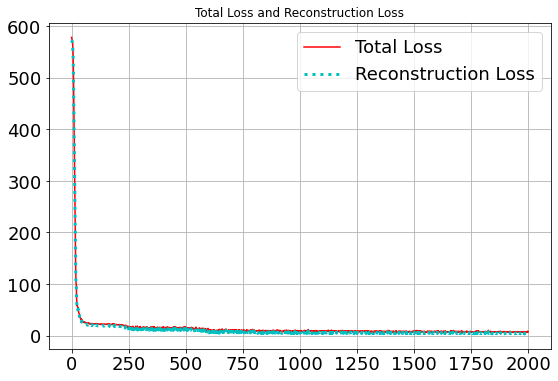

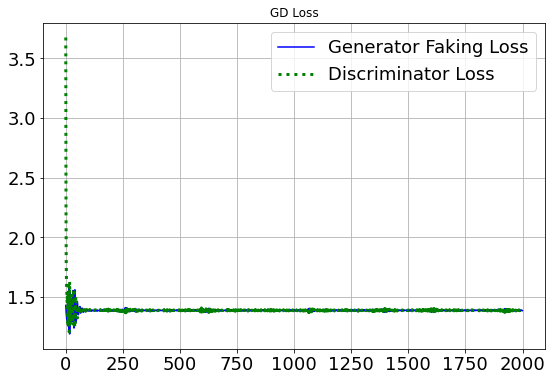

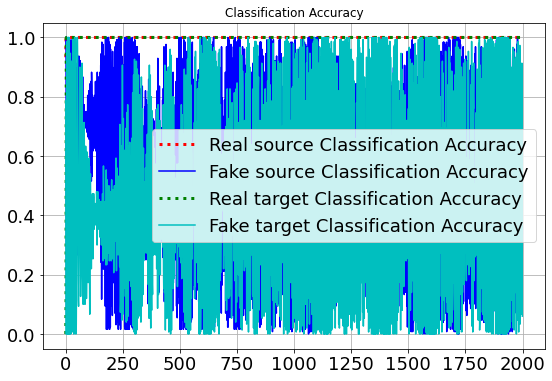

In [13]:
#plot GAN result
os.chdir(Dir_models)
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.plot(loss_recorder,'r')
plt.plot(glossrec_recorder,'c:',linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.legend(['Total Loss','Reconstruction Loss'],fontsize=18)
plt.title('Total Loss and Reconstruction Loss')
plt.savefig(specs+'loss.pdf',bbox_inches='tight')
plt.show()
plt.figure(figsize=(9,6))
plt.plot(gloss_recorder,'b')
plt.plot(dloss_recorder,'g:',linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.legend(['Generator Faking Loss','Discriminator Loss'],fontsize=18)
plt.title('GD Loss')
plt.savefig(specs+'gdloss.pdf',bbox_inches='tight')
plt.show()
plt.figure(figsize=(9,6))
plt.plot(true_acc_A_mean,'r:',linewidth=3)
plt.plot(fake_acc_A_mean,'b')
plt.plot(true_acc_B_mean,'g:',linewidth=3)
plt.plot(fake_acc_B_mean,'c')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.legend(['Real source Classification Accuracy','Fake source Classification Accuracy','Real target Classification Accuracy','Fake target Classification Accuracy'],fontsize=18)
plt.title('Classification Accuracy')
plt.savefig(specs+'accuracy.pdf',bbox_inches='tight')
plt.show()


In [14]:
#save data
Data_generated_dir = "/Users/yjl/Downloads/Stanford/CS 236G/Data_gen"
for datas in target_testloader:
    tgt_data = datas[0]
    tgt_gen_B = encoderB(tgt_data).detach().numpy()
    os.chdir(Data_generated_dir)
    np.save(specs+'.npy',tgt_gen_B)

In [15]:
# NN
class NN(nn.Module):
    def __init__(self, layers, dropout):
        
        super().__init__()
        
        fcs = []
        for i in range(len(layers) - 2):
            fcs.append(nn.Linear(layers[i], layers[i+1]))
            fcs.append(nn.ReLU())
            fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(layers[-2], layers[-1]))
        self.fc = nn.Sequential(*fcs)

        
    def forward(self, data):
        
        # data = [batch size, input_dim]
            
        return self.fc(data)

In [16]:
INPUT_DIM = 128
OUTPUT_DIM = 3
DROPOUT = 0.3
LAYERS = [INPUT_DIM, 64, 32, 16, OUTPUT_DIM]

model_nn = NN(LAYERS, DROPOUT)
model_nn.float()
opt_nn = optim.Adam(model_nn.parameters(),lr=1e-4)

criterion = nn.CrossEntropyLoss()

model_nn_GAN = NN(LAYERS, DROPOUT)
model_nn_GAN.float()
opt_nn_GAN = optim.Adam(model_nn_GAN.parameters(),lr=1e-4)

criterion_GAN = nn.CrossEntropyLoss()

In [17]:
def train(model, train_dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(train_dataloader)
    
    model.train()
    
    for _, batch in enumerate(train_dataloader):
        x, y = batch
        
        optimizer.zero_grad()
        
        predictions = model(x)
        
        loss = criterion(predictions, y)
        
        predictions = torch.argmax(torch.softmax(predictions, 1), dim=1)
        
        acc = torchmetrics.functional.accuracy(predictions, y)
        prec, recall = torchmetrics.functional.precision_recall(predictions, y, num_classes=3, average='macro')
        f1 = torchmetrics.functional.f1(predictions, y, num_classes=3, average='macro')
        
        loss.backward(retain_graph=True)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_f1 += f1.item()

    return epoch_loss / batches, epoch_acc / batches, epoch_prec / batches, epoch_recall / batches, epoch_f1 / batches



In [18]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(dataloader)
    
    model.eval()
    
    with torch.no_grad():
    
        for _, batch in enumerate(dataloader):
            x, y = batch

            predictions = model(x)
            
            loss = criterion(predictions, y)
            
            predictions = torch.argmax(torch.softmax(predictions, 1), dim=1)
            
            acc = torchmetrics.functional.accuracy(predictions, y)
            prec, recall = torchmetrics.functional.precision_recall(predictions, y, num_classes=3, average='macro')
            f1 = torchmetrics.functional.f1(predictions, y, num_classes=3, average='macro')

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / batches, epoch_acc / batches, epoch_prec / batches, epoch_recall / batches, epoch_f1 / batches

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



In [20]:
class HerbalData(Dataset):
    def __init__(self, x_train, y_train):
        assert len(x_train) == len(y_train)
        self.x = x_train
        self.y = y_train
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [21]:
#initiate training
x_train = torch.tensor(scr_train)
x_train_GAN = encoderA(x_train*torch.from_numpy(np.random.binomial(size=x_train.size(), n=1, p=1-noise)))
x_valid = t_train
x_test = t_test

train_set = HerbalData(x_train, torch.from_numpy(y_source))
train_GAN_set = HerbalData(x_train_GAN, torch.from_numpy(y_source))
valid_set = HerbalData(x_valid, torch.from_numpy(y_valid))
test_set = HerbalData(x_test, torch.from_numpy(y_test))

train_dataloader = DataLoader(train_set, batch_size=150, shuffle=True)
train_GAN_dataloader = DataLoader(train_GAN_set, batch_size=150, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)


print("Train Set:", x_train.shape)
print("Valid Set:", x_valid.shape)
print("Target Train Set:", x_test.shape)


Train Set: torch.Size([150, 128])
Valid Set: torch.Size([300, 128])
Target Train Set: torch.Size([180, 128])


In [22]:
N_EPOCHS = 150

train_loss = np.zeros(N_EPOCHS)
train_acc = np.zeros(N_EPOCHS)
train_prec = np.zeros(N_EPOCHS)
train_recall = np.zeros(N_EPOCHS)
train_f1 = np.zeros(N_EPOCHS)

train_GAN_loss = np.zeros(N_EPOCHS)
train_GAN_acc = np.zeros(N_EPOCHS)
train_GAN_prec = np.zeros(N_EPOCHS)
train_GAN_recall = np.zeros(N_EPOCHS)
train_GAN_f1 = np.zeros(N_EPOCHS)

valid_loss = np.zeros(N_EPOCHS)
valid_acc = np.zeros(N_EPOCHS)
valid_prec = np.zeros(N_EPOCHS)
valid_recall = np.zeros(N_EPOCHS)
valid_f1 = np.zeros(N_EPOCHS)

valid_GAN_loss = np.zeros(N_EPOCHS)
valid_GAN_acc = np.zeros(N_EPOCHS)
valid_GAN_prec = np.zeros(N_EPOCHS)
valid_GAN_recall = np.zeros(N_EPOCHS)
valid_GAN_f1 = np.zeros(N_EPOCHS)




best_valid_loss = float('inf')
best_valid_GAN_loss = float('inf')


#start train DNN
for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss[i], train_acc[i], train_prec[i], train_recall[i], train_f1[i] = train(model_nn, train_dataloader, opt_nn, criterion)
    valid_loss[i], valid_acc[i], valid_prec[i], valid_recall[i], valid_f1[i] = evaluate(model_nn, valid_dataloader, criterion)
    train_GAN_loss[i], train_GAN_acc[i], train_GAN_prec[i], train_GAN_recall[i], train_GAN_f1[i] = train(model_nn_GAN, train_GAN_dataloader, opt_nn_GAN, criterion_GAN)
    valid_GAN_loss[i], valid_GAN_acc[i], valid_GAN_prec[i], valid_GAN_recall[i], valid_GAN_f1[i] = evaluate(model_nn_GAN, valid_dataloader, criterion_GAN)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model_nn.state_dict(), 'nn-agg.pt')
    if valid_GAN_loss[i] < best_valid_GAN_loss:
        best_valid_GAN_loss = valid_GAN_loss[i]
        torch.save(model_nn.state_dict(), 'nn-agg-GAN.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. Acc: {valid_acc[i]*100:.2f}%')
    print(f'\tTrain GAN Loss: {train_GAN_loss[i]:.3f} | Train GAN Acc: {train_GAN_acc[i]*100:.2f}%')
    print(f'\t Val. GAN Loss: {valid_GAN_loss[i]:.3f} |  Val. GAN Acc: {valid_GAN_acc[i]*100:.2f}%')



Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.307 | Train Acc: 32.67%
	 Val. Loss: 1.135 |  Val. Acc: 8.00%
	Train GAN Loss: 1.445 | Train GAN Acc: 38.00%
	 Val. GAN Loss: 1.024 |  Val. GAN Acc: 38.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.320 | Train Acc: 26.67%
	 Val. Loss: 1.136 |  Val. Acc: 8.00%
	Train GAN Loss: 1.394 | Train GAN Acc: 36.67%
	 Val. GAN Loss: 1.029 |  Val. GAN Acc: 38.33%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.428 | Train Acc: 25.33%
	 Val. Loss: 1.135 |  Val. Acc: 8.00%
	Train GAN Loss: 1.551 | Train GAN Acc: 26.00%
	 Val. GAN Loss: 1.034 |  Val. GAN Acc: 41.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.300 | Train Acc: 28.67%
	 Val. Loss: 1.134 |  Val. Acc: 7.67%
	Train GAN Loss: 1.328 | Train GAN Acc: 36.67%
	 Val. GAN Loss: 1.039 |  Val. GAN Acc: 41.33%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.186 | Train Acc: 36.00%
	 Val. Loss: 1.133 |  Val. Acc: 7.67%
	Train GAN Loss: 1.412 | Train GAN Acc: 32.00%
	 Val. GAN Loss: 1.044 |  Val. GAN Acc: 41

Epoch: 46 | Epoch Time: 0m 0s
	Train Loss: 1.141 | Train Acc: 30.00%
	 Val. Loss: 1.106 |  Val. Acc: 32.33%
	Train GAN Loss: 1.125 | Train GAN Acc: 40.67%
	 Val. GAN Loss: 1.128 |  Val. GAN Acc: 30.00%
Epoch: 47 | Epoch Time: 0m 0s
	Train Loss: 1.128 | Train Acc: 36.00%
	 Val. Loss: 1.106 |  Val. Acc: 32.67%
	Train GAN Loss: 1.112 | Train GAN Acc: 37.33%
	 Val. GAN Loss: 1.129 |  Val. GAN Acc: 30.33%
Epoch: 48 | Epoch Time: 0m 0s
	Train Loss: 1.187 | Train Acc: 30.00%
	 Val. Loss: 1.106 |  Val. Acc: 32.67%
	Train GAN Loss: 1.060 | Train GAN Acc: 41.33%
	 Val. GAN Loss: 1.130 |  Val. GAN Acc: 30.33%
Epoch: 49 | Epoch Time: 0m 0s
	Train Loss: 1.165 | Train Acc: 33.33%
	 Val. Loss: 1.106 |  Val. Acc: 32.67%
	Train GAN Loss: 1.086 | Train GAN Acc: 43.33%
	 Val. GAN Loss: 1.131 |  Val. GAN Acc: 31.00%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 1.110 | Train Acc: 41.33%
	 Val. Loss: 1.107 |  Val. Acc: 32.67%
	Train GAN Loss: 1.083 | Train GAN Acc: 40.00%
	 Val. GAN Loss: 1.131 |  Val. GAN Ac

Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 1.035 | Train Acc: 43.33%
	 Val. Loss: 1.100 |  Val. Acc: 35.33%
	Train GAN Loss: 0.983 | Train GAN Acc: 49.33%
	 Val. GAN Loss: 1.185 |  Val. GAN Acc: 33.33%
Epoch: 95 | Epoch Time: 0m 0s
	Train Loss: 1.066 | Train Acc: 42.67%
	 Val. Loss: 1.100 |  Val. Acc: 35.67%
	Train GAN Loss: 0.994 | Train GAN Acc: 50.67%
	 Val. GAN Loss: 1.187 |  Val. GAN Acc: 33.33%
Epoch: 96 | Epoch Time: 0m 0s
	Train Loss: 1.083 | Train Acc: 36.00%
	 Val. Loss: 1.100 |  Val. Acc: 35.67%
	Train GAN Loss: 0.989 | Train GAN Acc: 48.67%
	 Val. GAN Loss: 1.189 |  Val. GAN Acc: 33.33%
Epoch: 97 | Epoch Time: 0m 0s
	Train Loss: 1.076 | Train Acc: 38.67%
	 Val. Loss: 1.100 |  Val. Acc: 35.67%
	Train GAN Loss: 1.009 | Train GAN Acc: 44.67%
	 Val. GAN Loss: 1.190 |  Val. GAN Acc: 33.33%
Epoch: 98 | Epoch Time: 0m 0s
	Train Loss: 1.029 | Train Acc: 48.67%
	 Val. Loss: 1.100 |  Val. Acc: 35.67%
	Train GAN Loss: 0.951 | Train GAN Acc: 46.67%
	 Val. GAN Loss: 1.192 |  Val. GAN Ac

Epoch: 139 | Epoch Time: 0m 0s
	Train Loss: 1.050 | Train Acc: 37.33%
	 Val. Loss: 1.092 |  Val. Acc: 36.00%
	Train GAN Loss: 0.902 | Train GAN Acc: 50.67%
	 Val. GAN Loss: 1.311 |  Val. GAN Acc: 34.00%
Epoch: 140 | Epoch Time: 0m 0s
	Train Loss: 1.040 | Train Acc: 46.67%
	 Val. Loss: 1.092 |  Val. Acc: 35.67%
	Train GAN Loss: 0.915 | Train GAN Acc: 52.67%
	 Val. GAN Loss: 1.314 |  Val. GAN Acc: 34.00%
Epoch: 141 | Epoch Time: 0m 0s
	Train Loss: 1.045 | Train Acc: 41.33%
	 Val. Loss: 1.091 |  Val. Acc: 35.67%
	Train GAN Loss: 0.860 | Train GAN Acc: 57.33%
	 Val. GAN Loss: 1.318 |  Val. GAN Acc: 34.00%
Epoch: 142 | Epoch Time: 0m 0s
	Train Loss: 1.013 | Train Acc: 42.00%
	 Val. Loss: 1.091 |  Val. Acc: 36.00%
	Train GAN Loss: 0.871 | Train GAN Acc: 55.33%
	 Val. GAN Loss: 1.322 |  Val. GAN Acc: 34.00%
Epoch: 143 | Epoch Time: 0m 0s
	Train Loss: 1.001 | Train Acc: 44.67%
	 Val. Loss: 1.090 |  Val. Acc: 35.67%
	Train GAN Loss: 0.869 | Train GAN Acc: 57.33%
	 Val. GAN Loss: 1.326 |  Val. G

In [23]:
#test
model_nn.load_state_dict(torch.load('nn-agg.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model_nn, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

model_nn_GAN.load_state_dict(torch.load('nn-agg-GAN.pt'))

test_GAN_loss, test_GAN_acc, test_GAN_prec, test_GAN_recall, test_GAN_f1 = evaluate(model_nn_GAN, test_dataloader, criterion_GAN)
print(f'Test GAN Loss: {test_GAN_loss:.3f} | Test GAN Acc: {test_GAN_acc*100:.2f}% | Test GAN Prec: {test_GAN_prec*100:.2f}% | Test GAN Recall: {test_GAN_recall*100:.2f}% | Test GAN F1: {test_GAN_f1*100:.2f}%')


Test Loss: 1.107 | Test Acc: 36.67% | Test Prec: 33.99% | Test Recall: 36.67% | Test F1: 23.19%
Test GAN Loss: 1.141 | Test GAN Acc: 9.44% | Test GAN Prec: 38.91% | Test GAN Recall: 9.44% | Test GAN F1: 7.79%


# Bootstrapping

In [24]:
#bootstrapping
boot = 100
results  = []
test_GAN_loss_list, test_GAN_acc_list, test_GAN_prec_list, test_GAN_recall_list, test_GAN_f1_list = [],[],[],[],[]

for i in range(boot):
    np.random.seed(i)
    boot_idx = np.random.randint(0,150, size=(150,))
    #print(boot_idx)
    Xs_boot = Xs[boot_idx,:]
    Xs_boot = encoderA(torch.from_numpy(Xs_boot).float()*torch.from_numpy(np.random.binomial(size=x_train.size(), n=1, p=1-noise)))
    Ys_boot = y_source[boot_idx]
    
    train_GAN_set_boot = HerbalData(Xs_boot, torch.from_numpy(Ys_boot))
    
   
    #train_GAN_set_boot = train_GAN_set[boot_idx]
    train_GAN_dataloader_boot = DataLoader(train_GAN_set_boot, batch_size=128, shuffle=True)
    test_GAN_loss, test_GAN_acc, test_GAN_prec, test_GAN_recall, test_GAN_f1 = evaluate(model_nn_GAN, train_GAN_dataloader_boot, criterion_GAN)
    #print(test_GAN_acc)
    
    test_GAN_loss_list.append(test_GAN_loss)
    test_GAN_acc_list.append(test_GAN_acc) 
    test_GAN_prec_list.append(test_GAN_prec) 
    test_GAN_recall_list.append(test_GAN_recall) 
    test_GAN_f1_list.append(test_GAN_f1)


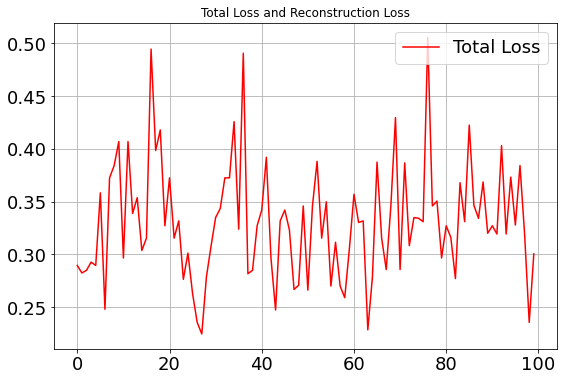

In [25]:
#bootstrapping painting
#print(test_GAN_acc_list)
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.plot(test_GAN_acc_list,'r')
#plt.plot(glossrec_recorder,'c:',linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.legend(['Total Loss','Generator Faking Loss','Discriminator Loss','Generator Reconstruction Loss'],fontsize=18)
plt.title('Total Loss and Reconstruction Loss')
plt.savefig(specs+'loss.pdf',bbox_inches='tight')
plt.show()

In [26]:
from numpy import mean
print("bootstrapping test acc with GAN:", mean(test_GAN_acc_list))

bootstrapping test acc with GAN: 0.33050426267087457


In [27]:
from sklearn.metrics import confusion_matrix as cfm
def predict(model, x):
    x = torch.from_numpy(x)
    with torch.no_grad():
        return torch.argmax(torch.softmax(model(x), 1), dim=1).detach().numpy()

In [28]:
def confusion_matrix_plot(y_pred, y_true):
    cm = cfm(y_pred, y_true, normalize='true')
    #print(cm)
    normalize = True
    cmap = 'RdPu'
    classes = [0, 1, 2]
    title = 'cofusion matrix'
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax = ax)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
            fig.tight_layout()

def metric_epoch(train_loss, valid_loss, train_f1, valid_f1):
    x = range(0, len(train_loss))
    plt.figure(figsize=(14,3))
    grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
    plt.subplot(grid[:,0])
    plt.plot(x, train_f1, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train F1 score')
    plt.plot(x, valid_f1, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid F1 score')
    plt.legend()
    plt.title('F1 score vs epoches')
    plt.xlabel('epoches')
    plt.ylabel('F1 score')
    plt.subplot(grid[:,1])
    plt.plot(x, train_loss, color="red", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train Loss')
    plt.plot(x, valid_loss, color="blue", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid Loss')
    plt.legend()
    plt.title('Loss vs epoches')
    plt.xlabel('epoches')
    plt.ylabel('Loss')
    plt.show()


[1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


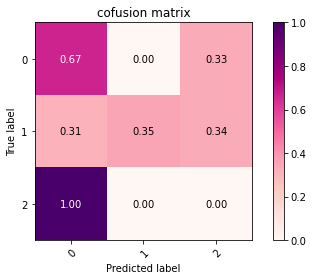

In [29]:
y_test_prediction = predict(model_nn, x_test.numpy())
#print(y_target_train)
confusion_matrix_plot(y_test_prediction, y_test)
print(y_test_prediction)

[1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 0 2 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


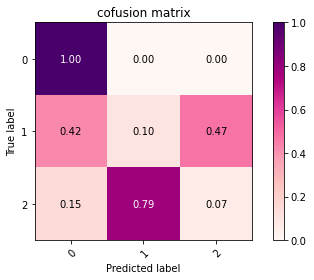

In [30]:
y_test_prediction_GAN = predict(model_nn_GAN, x_test.numpy())
#print(y_target_train)
confusion_matrix_plot(y_test_prediction_GAN, y_test)
print(y_test_prediction_GAN)

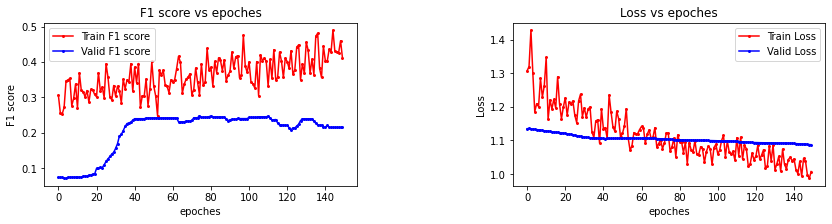

In [31]:
metric_epoch(train_loss, valid_loss, train_f1, valid_f1)

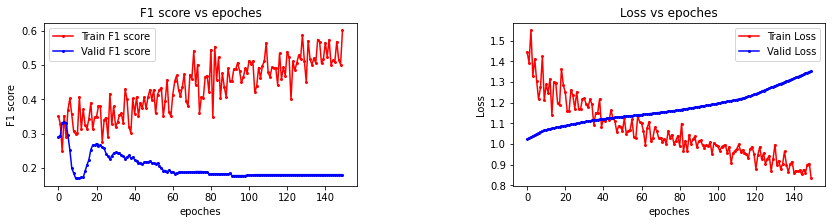

In [32]:
metric_epoch(train_GAN_loss, valid_GAN_loss, train_GAN_f1, valid_GAN_f1)

# DRCA

In [33]:
class DRCA():
    '''
    The DRCA Class
    '''
    def __init__(self, n_components = 2,alpha = None, mode = 'raw'):
        '''
        The function to initialize the DRCA class
        :param n_components: The intended dimensionality of projection hyperplane smaller than the initial dimensionality
        :param alpha: weighting factor for target domain data within class scatter
        :param mode: the mode of DRCA:
            'raw': consider source domain data (S) and target domain data (T) as two groups
            'number': consider type-specific source domain data and target domain data based on the average number of cases in S and T
            'mean': equal weights for each class
        '''
        self.mode = mode
        self.Sw_s = None
        self.Sw_t = None
        self.mu_s = None
        self.mu_t = None
        self.alpha = alpha
        self.D_tilde = n_components
    pass

    def fit(self, Xs, Xt, Ys=None, Yt = None):
        '''
        This function fit the DRCA model with the data and labels given by users
        :param Xs: the feature matrix of shape (Ns, D) in source domain, np.array
        :param Xt: the feature matrix of shape (Nt, D) in target domain, np.array
        :param Ys: the label of the data of shape (Ns,) in source domain, np.array, int
        :param Yt: the label of the data of shape (Nt,) in target domain, np.array, int
        '''
        ### --- Summarize statistics --- ###
        if self.mode != 'raw':
            Ys = Ys.reshape(-1,) #we need to use Y and make sure the Y is the intended form
            Yt = Yt.reshape(-1,)
        Ns = Xs.shape[0]
        Nt = Xt.shape[0]
        D = Xs.shape[1]
        
        ### --- Within-domain scatter --- ###
        self.mu_s = np.mean(Xs,axis=0,keepdims=True) #1*D
        self.mu_t = np.mean(Xt,axis=0,keepdims=True)
        self.Sw_s = (Xs - self.mu_s).T @ (Xs - self.mu_s) #D*D
        self.Sw_t = (Xt - self.mu_t).T @ (Xt - self.mu_t) #D*D
        if self.alpha == None:
            self.alpha = Ns/Nt
        self.nominator = self.Sw_s + self.Sw_t * self.alpha
        
        ### --- Eliminate sensor drifts --- ###
        if self.mode == 'raw': #S and T as two entities
            self.denominator = (self.mu_s - self.mu_t).T @ (self.mu_s-self.mu_t) #D*D
        elif self.mode == 'number': #Focus on the same classes appeared in target domain
            Kt = np.unique(Yt).shape[0] #Assume that the target domain classes are fewer 
            self.denominator = np.empty((D,D))
            for i in range(Kt):
                Ns = np.mean(Ys==Kt[i])
                Nt = np.mean(Yt==Kt[i])
                N = 0.5*(self.Ns+self.Nt)#self. ???????????????????
                mu_s_matrix = np.mean(Xs[Ys==Kt[i],:],axis=0,keepdims=True)
                mu_t_matrix = np.mean(Xt[Yt==Kt[i],:],axis=0,keepdims=True)
                Sb_matrix = (self.mu_s_matrix-self.mu_t_matrix).T @ (self.mu_s_matrix-self.mu_t_matrix)
                self.denomiator += N * Sb_matrix
        elif self.mode == 'mean': #Equal weights for every class
            Kt = np.unique(Yt).shape[0] #Assume that the target domain classes are fewer 
            self.denominator = np.empty((D,D))
            for i in range(Kt):
                mu_s_matrix = np.mean(Xs[Ys==Kt[i],:],axis=0,keepdims=True)#1*D
                mu_t_matrix = np.mean(Xt[Yt==Kt[i],:],axis=0,keepdims=True)#1*D
                Sb_matrix = (self.mu_s_matrix-self.mu_t_matrix).T @ (self.mu_s_matrix-self.mu_t_matrix)
                self.denomiator += Sb_matrix#D*D
        
        
        eigenValues, eigenVectors = np.linalg.eig(np.linalg.pinv(self.denominator) @ self.nominator) #D*D

        idx = np.abs(eigenValues).argsort()[::-1]  
        self.eigenValues = eigenValues[idx]
        self.eigenVectors = eigenVectors[:,idx]
        self.W = self.eigenVectors[:,0:self.D_tilde]#shape=(D,D_tilde)
    pass    
        
    def transform(self, X):
        '''
        This function use the fitted SRLDA model
        :param X: the data in np.array of shape (N,D) that needs to be projected to the lower dimension
        :return: X_tilde: the projected data in the lower dimensional space in np.array of shape (N, D_tilde)
        '''
        return np.matmul(X,self.W)   #goal:  (N,D_tilde)      (D_tilde*D)@(D*N).T     (N*D)(D*D_tilde)
    pass
    
    def fit_transform(self, Xs, Xt, Ys=None, Yt = None):
        '''
        :param Xs: the feature matrix of shape (Ns, D) in source domain, np.array
        :param Xt: the feature matrix of shape (Nt, D) in target domain, np.array
        :param Ys: the label of the data of shape (Ns,) in source domain, np.array, int
        :param Yt: the label of the data of shape (Nt,) in target domain, np.array, int '''
                                                  
        self.fit(Xs, Xt, Ys, Yt)
        return np.real(self.transform(Xs)),np.real(self.transform(Xt)) #N * D_tilde
    pass

In [34]:
# With DRCA
drca=DRCA(n_components=50, alpha=0.01)#n_components and alpha value are hyperparameters
Xs_drca, Xt_drca = drca.fit_transform(Xs,Xt)

#Target domain train test split
train_idx = np.concatenate((np.arange(0,100),np.arange(160,260),np.arange(320,420))).reshape(-1,)
test_idx = np.concatenate((np.arange(100,160),np.arange(260,320),np.arange(420,480))).reshape(-1,)

# Labels
y_target=np.hstack((0*np.ones(160),1*np.ones(160),2*np.ones(160))).astype(np.int64)
y_source=np.hstack((0*np.ones(50),1*np.ones(50),2*np.ones(50))).astype(np.int64)

#X and Y, need to change to our data
XA_drca_train = Xs_drca
XB_drca_train = Xt_drca[train_idx,:]
assert XB_drca_train.shape[0] == 300
XA_drca_test = Xs_drca
XB_drca_test = Xt_drca[test_idx,:]
assert XB_drca_test.shape[0] == 180
y_valid = y_target[train_idx]
assert y_valid.shape[0] == 300
y_test = y_target[test_idx]
assert y_test.shape[0] == 180

scr_drca_train = Variable(torch.from_numpy(XA_drca_train).float())
tgt_drca_train = Variable(torch.from_numpy(XB_drca_train).float())
tgt_drca_test = Variable(torch.from_numpy(XB_drca_test).float())


x_drca_train = torch.tensor(scr_drca_train)
x_drca_valid = torch.tensor(tgt_drca_train)    
x_drca_test = torch.tensor(tgt_drca_test)

train_drca_set = HerbalData(x_drca_train, torch.from_numpy(y_source))
valid_drca_set = HerbalData(x_drca_valid, torch.from_numpy(y_valid))
test_drca_set = HerbalData(x_drca_test, torch.from_numpy(y_test))

train_drca_dataloader = DataLoader(train_drca_set, batch_size=150, shuffle=True)
valid_drca_dataloader = DataLoader(valid_drca_set, batch_size=len(valid_drca_set), shuffle=True)
test_drca_dataloader = DataLoader(test_drca_set, batch_size=len(test_drca_set), shuffle=True)


print("Train Set:", x_drca_train.shape)
print("Valid Set:", x_drca_valid.shape)
print("Target Train Set:", x_drca_test.shape)





Train Set: torch.Size([150, 50])
Valid Set: torch.Size([300, 50])
Target Train Set: torch.Size([180, 50])


In [35]:
print(Xs_drca.shape)
INPUT_DIM = Xs_drca.shape[1]
OUTPUT_DIM = 3
DROPOUT = 0.3
LAYERS = [INPUT_DIM, 64, 32, 16, OUTPUT_DIM]

model_drca_nn = NN(LAYERS, DROPOUT)
model_drca_nn.float()
opt_drca_nn = optim.Adam(model_drca_nn.parameters(),lr=1e-4)

criterion_drca = nn.CrossEntropyLoss()

(150, 50)


In [36]:
N_EPOCHS = 150

train_drca_loss = np.zeros(N_EPOCHS)
train_drca_acc = np.zeros(N_EPOCHS)
train_drca_prec = np.zeros(N_EPOCHS)
train_drca_recall = np.zeros(N_EPOCHS)
train_drca_f1 = np.zeros(N_EPOCHS)

valid_drca_loss = np.zeros(N_EPOCHS)
valid_drca_acc = np.zeros(N_EPOCHS)
valid_drca_prec = np.zeros(N_EPOCHS)
valid_drca_recall = np.zeros(N_EPOCHS)
valid_drca_f1 = np.zeros(N_EPOCHS)




best_valid_drca_loss = float('inf')

for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_drca_loss[i], train_drca_acc[i], train_drca_prec[i], train_drca_recall[i], train_drca_f1[i] = train(model_drca_nn, train_drca_dataloader, opt_drca_nn, criterion_drca)
    valid_drca_loss[i], valid_drca_acc[i], valid_drca_prec[i], valid_drca_recall[i], valid_drca_f1[i] = evaluate(model_drca_nn, valid_drca_dataloader, criterion_drca)
    
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_drca_loss[i] < best_valid_drca_loss:
        best_valid_ldrca_oss = valid_drca_loss[i]
        torch.save(model_nn.state_dict(), 'nn-agg-drca.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_drca_loss[i]:.3f} | Train Acc: {train_drca_acc[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_drca_loss[i]:.3f} |  Val. Acc: {valid_drca_acc[i]*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.097 | Train Acc: 32.67%
	 Val. Loss: 1.099 |  Val. Acc: 31.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.100 | Train Acc: 29.33%
	 Val. Loss: 1.099 |  Val. Acc: 31.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.102 | Train Acc: 22.67%
	 Val. Loss: 1.099 |  Val. Acc: 28.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.101 | Train Acc: 25.33%
	 Val. Loss: 1.099 |  Val. Acc: 28.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.101 | Train Acc: 28.00%
	 Val. Loss: 1.098 |  Val. Acc: 28.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 1.099 | Train Acc: 32.00%
	 Val. Loss: 1.098 |  Val. Acc: 28.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 1.100 | Train Acc: 36.67%
	 Val. Loss: 1.098 |  Val. Acc: 29.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.103 | Train Acc: 26.00%
	 Val. Loss: 1.098 |  Val. Acc: 29.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.100 | Train Acc: 30.00%
	 Val. Loss: 1.098 |  Val. Acc: 28.67%
Epoch: 10 | Epoch Time: 0m 0

Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 1.095 | Train Acc: 40.00%
	 Val. Loss: 1.094 |  Val. Acc: 33.33%
Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 1.096 | Train Acc: 34.67%
	 Val. Loss: 1.094 |  Val. Acc: 33.33%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 1.096 | Train Acc: 32.00%
	 Val. Loss: 1.094 |  Val. Acc: 33.00%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 1.096 | Train Acc: 38.00%
	 Val. Loss: 1.094 |  Val. Acc: 33.00%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 1.097 | Train Acc: 39.33%
	 Val. Loss: 1.094 |  Val. Acc: 32.67%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 1.101 | Train Acc: 33.33%
	 Val. Loss: 1.094 |  Val. Acc: 33.00%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 1.095 | Train Acc: 40.00%
	 Val. Loss: 1.094 |  Val. Acc: 33.00%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 1.096 | Train Acc: 34.67%
	 Val. Loss: 1.094 |  Val. Acc: 33.00%
Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 1.097 | Train Acc: 30.00%
	 Val. Loss: 1.094 |  Val. Acc: 33.00%
Epoch: 87 | Epoch Time: 0m 0

In [37]:
#test
#model_drca_nn.load_state_dict(torch.load('nn-agg-drca.pt'))

test_drca_loss, test_drca_acc, test_drca_prec, test_drca_recall, test_drca_f1 = evaluate(model_drca_nn, test_drca_dataloader, criterion_drca)
print(f'Test Loss: {test_drca_loss:.3f} | Test Acc: {test_drca_acc*100:.2f}% | Test Prec: {test_drca_prec*100:.2f}% | Test Recall: {test_drca_recall*100:.2f}% | Test F1: {test_drca_f1*100:.2f}%')


Test Loss: 1.093 | Test Acc: 30.00% | Test Prec: 50.50% | Test Recall: 30.00% | Test F1: 25.28%


# GAN_DRCA

In [83]:
# With DRCA
drca=DRCA(n_components=50, alpha=0.01)#n_components and alpha value are hyperparameters
Xs_GAN = encoderA(torch.tensor(scr_train)*torch.from_numpy(np.random.binomial(size=scr_train.size(), n=1, p=1-noise)))

Xs_drca, Xt_drca = drca.fit_transform(Xs_GAN.detach().numpy(),Xt)

#Target domain train test split
train_idx = np.concatenate((np.arange(0,100),np.arange(160,260),np.arange(320,420))).reshape(-1,)
test_idx = np.concatenate((np.arange(100,160),np.arange(260,320),np.arange(420,480))).reshape(-1,)

# Labels
y_target=np.hstack((0*np.ones(160),1*np.ones(160),2*np.ones(160))).astype(np.int64)
y_source=np.hstack((0*np.ones(50),1*np.ones(50),2*np.ones(50))).astype(np.int64)

#X and Y, need to change to our data
XA_drca_train = Xs_drca
XB_drca_train = Xt_drca[train_idx,:]
assert XB_drca_train.shape[0] == 300
XA_drca_test = Xs_drca
XB_drca_test = Xt_drca[test_idx,:]
assert XB_drca_test.shape[0] == 180
y_valid = y_target[train_idx]
assert y_valid.shape[0] == 300
y_test = y_target[test_idx]
assert y_test.shape[0] == 180

scr_drca_train = Variable(torch.from_numpy(XA_drca_train).float())
tgt_drca_train = Variable(torch.from_numpy(XB_drca_train).float())
tgt_drca_test = Variable(torch.from_numpy(XB_drca_test).float())


x_drca_train = torch.tensor(scr_drca_train)
x_drca_valid = torch.tensor(tgt_drca_train)    
x_drca_test = torch.tensor(tgt_drca_test)

train_drca_set = HerbalData(x_drca_train, torch.from_numpy(y_source))
valid_drca_set = HerbalData(x_drca_valid, torch.from_numpy(y_valid))
test_drca_set = HerbalData(x_drca_test, torch.from_numpy(y_test))

train_drca_dataloader = DataLoader(train_drca_set, batch_size=150, shuffle=True)
valid_drca_dataloader = DataLoader(valid_drca_set, batch_size=len(valid_drca_set), shuffle=True)
test_drca_dataloader = DataLoader(test_drca_set, batch_size=len(test_drca_set), shuffle=True)


print("Train Set:", x_drca_train.shape)
print("Valid Set:", x_drca_valid.shape)
print("Target Train Set:", x_drca_test.shape)


Train Set: torch.Size([150, 50])
Valid Set: torch.Size([300, 50])
Target Train Set: torch.Size([180, 50])


In [84]:
print(Xs_drca.shape)
INPUT_DIM = Xs_drca.shape[1]
OUTPUT_DIM = 3
DROPOUT = 0.3
LAYERS = [INPUT_DIM, 64, 32, 16, OUTPUT_DIM]

model_drca_nn = NN(LAYERS, DROPOUT)
model_drca_nn.float()
opt_drca_nn = optim.Adam(model_drca_nn.parameters(),lr=1e-4)

criterion_drca = nn.CrossEntropyLoss()

(150, 50)


In [85]:
N_EPOCHS = 150

train_drca_loss = np.zeros(N_EPOCHS)
train_drca_acc = np.zeros(N_EPOCHS)
train_drca_prec = np.zeros(N_EPOCHS)
train_drca_recall = np.zeros(N_EPOCHS)
train_drca_f1 = np.zeros(N_EPOCHS)

valid_drca_loss = np.zeros(N_EPOCHS)
valid_drca_acc = np.zeros(N_EPOCHS)
valid_drca_prec = np.zeros(N_EPOCHS)
valid_drca_recall = np.zeros(N_EPOCHS)
valid_drca_f1 = np.zeros(N_EPOCHS)




best_valid_drca_loss = float('inf')

for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_drca_loss[i], train_drca_acc[i], train_drca_prec[i], train_drca_recall[i], train_drca_f1[i] = train(model_drca_nn, train_drca_dataloader, opt_drca_nn, criterion_drca)
    valid_drca_loss[i], valid_drca_acc[i], valid_drca_prec[i], valid_drca_recall[i], valid_drca_f1[i] = evaluate(model_drca_nn, valid_drca_dataloader, criterion_drca)
    
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_drca_loss[i] < best_valid_drca_loss:
        best_valid_ldrca_oss = valid_drca_loss[i]
        torch.save(model_nn.state_dict(), 'nn-agg-drca.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_drca_loss[i]:.3f} | Train Acc: {train_drca_acc[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_drca_loss[i]:.3f} |  Val. Acc: {valid_drca_acc[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.098 | Train Acc: 36.00%
	 Val. Loss: 1.101 |  Val. Acc: 34.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.104 | Train Acc: 31.33%
	 Val. Loss: 1.100 |  Val. Acc: 34.33%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.101 | Train Acc: 37.33%
	 Val. Loss: 1.100 |  Val. Acc: 35.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.102 | Train Acc: 27.33%
	 Val. Loss: 1.100 |  Val. Acc: 35.33%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.105 | Train Acc: 29.33%
	 Val. Loss: 1.100 |  Val. Acc: 35.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 1.105 | Train Acc: 33.33%
	 Val. Loss: 1.099 |  Val. Acc: 35.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 1.101 | Train Acc: 34.67%
	 Val. Loss: 1.099 |  Val. Acc: 35.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.101 | Train Acc: 37.33%
	 Val. Loss: 1.099 |  Val. Acc: 35.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.100 | Train Acc: 38.00%
	 Val. Loss: 1.099 |  Val. Acc: 35.67%
Epoch: 10 | Epoch Time: 0m 0

Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 1.083 | Train Acc: 42.00%
	 Val. Loss: 1.081 |  Val. Acc: 47.00%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 1.084 | Train Acc: 42.00%
	 Val. Loss: 1.080 |  Val. Acc: 47.00%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 1.080 | Train Acc: 42.00%
	 Val. Loss: 1.080 |  Val. Acc: 47.00%
Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 1.087 | Train Acc: 33.33%
	 Val. Loss: 1.080 |  Val. Acc: 47.00%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 1.079 | Train Acc: 41.33%
	 Val. Loss: 1.079 |  Val. Acc: 47.00%
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 1.073 | Train Acc: 48.67%
	 Val. Loss: 1.079 |  Val. Acc: 47.00%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 1.078 | Train Acc: 46.67%
	 Val. Loss: 1.079 |  Val. Acc: 47.00%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 1.078 | Train Acc: 43.33%
	 Val. Loss: 1.078 |  Val. Acc: 47.00%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 1.076 | Train Acc: 49.33%
	 Val. Loss: 1.078 |  Val. Acc: 47.00%
Epoch: 95 | Epoch Time: 0m 0

In [86]:
#test
#model_drca_nn.load_state_dict(torch.load('nn-agg-drca.pt'))

test_drca_loss, test_drca_acc, test_drca_prec, test_drca_recall, test_drca_f1 = evaluate(model_drca_nn, test_drca_dataloader, criterion_drca)
print(f'Test Loss: {test_drca_loss:.3f} | Test Acc: {test_drca_acc*100:.2f}% | Test Prec: {test_drca_prec*100:.2f}% | Test Recall: {test_drca_recall*100:.2f}% | Test F1: {test_drca_f1*100:.2f}%')


Test Loss: 1.082 | Test Acc: 38.33% | Test Prec: 34.71% | Test Recall: 38.33% | Test F1: 26.91%


# GAN_KMM

In [56]:
import scipy
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

def transform(Xs, Xt, dim=30, kernel_type='primal'):
    '''
    Transform Xs and Xt
    :param Xs: ns * n_feature, source feature
    :param Xt: nt * n_feature, target feature
    :return: Xs_new and Xt_new
    '''
    kernel_type = 'primal'
    lamb = 1
    gamma = 1

    X = np.hstack((Xs.T, Xt.T))
    X /= np.linalg.norm(X, axis=0)
    m, n = X.shape
    ns, nt = len(Xs), len(Xt)
    e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
    M = e * e.T
    M = M / np.linalg.norm(M, 'fro')
    H = np.eye(n) - 1 / n * np.ones((n, n))
    K = kernel('primal', X, None, gamma=gamma)
    n_eye = m if kernel_type == 'primal' else n
    a, b = np.linalg.multi_dot([K, M, K.T]) + lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
    w, V = scipy.linalg.eig(a, b)
    ind = np.argsort(w)
    A = V[:, ind[:dim]]
    Z = np.dot(A.T, K)
    Z /= np.linalg.norm(Z, axis=0)
    Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
    return Xs_new, Xt_new

In [57]:
# With KMM
drca=DRCA(n_components=50, alpha=0.01)#n_components and alpha value are hyperparameters
Xs_GAN = encoderA(torch.tensor(scr_train)*torch.from_numpy(np.random.binomial(size=scr_train.size(), n=1, p=1-noise)))

Xs_drca, Xt_drca = transform(Xs=Xs, Xt=Xt, dim=50, kernel_type='primal')

#Target domain train test split
train_idx = np.concatenate((np.arange(0,100),np.arange(160,260),np.arange(320,420))).reshape(-1,)
test_idx = np.concatenate((np.arange(100,160),np.arange(260,320),np.arange(420,480))).reshape(-1,)

# Labels
y_target=np.hstack((0*np.ones(160),1*np.ones(160),2*np.ones(160))).astype(np.int64)
y_source=np.hstack((0*np.ones(50),1*np.ones(50),2*np.ones(50))).astype(np.int64)

#X and Y, need to change to our data
XA_drca_train = Xs_drca
XB_drca_train = Xt_drca[train_idx,:]
assert XB_drca_train.shape[0] == 300
XA_drca_test = Xs_drca
XB_drca_test = Xt_drca[test_idx,:]
assert XB_drca_test.shape[0] == 180
y_valid = y_target[train_idx]
assert y_valid.shape[0] == 300
y_test = y_target[test_idx]
assert y_test.shape[0] == 180

scr_drca_train = Variable(torch.from_numpy(XA_drca_train).float())
tgt_drca_train = Variable(torch.from_numpy(XB_drca_train).float())
tgt_drca_test = Variable(torch.from_numpy(XB_drca_test).float())


x_drca_train = torch.tensor(scr_drca_train)
x_drca_valid = torch.tensor(tgt_drca_train)    
x_drca_test = torch.tensor(tgt_drca_test)

train_drca_set = HerbalData(x_drca_train, torch.from_numpy(y_source))
valid_drca_set = HerbalData(x_drca_valid, torch.from_numpy(y_valid))
test_drca_set = HerbalData(x_drca_test, torch.from_numpy(y_test))

train_drca_dataloader = DataLoader(train_drca_set, batch_size=150, shuffle=True)
valid_drca_dataloader = DataLoader(valid_drca_set, batch_size=len(valid_drca_set), shuffle=True)
test_drca_dataloader = DataLoader(test_drca_set, batch_size=len(test_drca_set), shuffle=True)


print("Train Set:", x_drca_train.shape)
print("Valid Set:", x_drca_valid.shape)
print("Target Train Set:", x_drca_test.shape)


Train Set: torch.Size([150, 50])
Valid Set: torch.Size([300, 50])
Target Train Set: torch.Size([180, 50])


In [69]:
print(Xs_drca.shape)
INPUT_DIM = Xs_drca.shape[1]
OUTPUT_DIM = 3
DROPOUT = 0.3
LAYERS = [INPUT_DIM, 64, 32, 16, OUTPUT_DIM]

model_drca_nn = NN(LAYERS, DROPOUT)
model_drca_nn.float()
opt_drca_nn = optim.Adam(model_drca_nn.parameters(),lr=1e-4)

criterion_drca = nn.CrossEntropyLoss()

(150, 50)


In [70]:
N_EPOCHS = 150

train_drca_loss = np.zeros(N_EPOCHS)
train_drca_acc = np.zeros(N_EPOCHS)
train_drca_prec = np.zeros(N_EPOCHS)
train_drca_recall = np.zeros(N_EPOCHS)
train_drca_f1 = np.zeros(N_EPOCHS)

valid_drca_loss = np.zeros(N_EPOCHS)
valid_drca_acc = np.zeros(N_EPOCHS)
valid_drca_prec = np.zeros(N_EPOCHS)
valid_drca_recall = np.zeros(N_EPOCHS)
valid_drca_f1 = np.zeros(N_EPOCHS)




best_valid_drca_loss = float('inf')

for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_drca_loss[i], train_drca_acc[i], train_drca_prec[i], train_drca_recall[i], train_drca_f1[i] = train(model_drca_nn, train_drca_dataloader, opt_drca_nn, criterion_drca)
    valid_drca_loss[i], valid_drca_acc[i], valid_drca_prec[i], valid_drca_recall[i], valid_drca_f1[i] = evaluate(model_drca_nn, valid_drca_dataloader, criterion_drca)
    
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_drca_loss[i] < best_valid_drca_loss:
        best_valid_ldrca_oss = valid_drca_loss[i]
        torch.save(model_nn.state_dict(), 'nn-agg-drca.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_drca_loss[i]:.3f} | Train Acc: {train_drca_acc[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_drca_loss[i]:.3f} |  Val. Acc: {valid_drca_acc[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.106 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.110 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.109 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.111 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.109 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 1.112 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 1.107 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.110 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.110 | Train Acc: 33.33%
	 Val. Loss: 1.110 |  Val. Acc: 33.33%
Epoch: 10 | Epoch Time: 0m 0

Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 1.108 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 1.103 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 1.108 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 1.103 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 95 | Epoch Time: 0m 0s
	Train Loss: 1.108 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 96 | Epoch Time: 0m 0s
	Train Loss: 1.104 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 97 | Epoch Time: 0m 0s
	Train Loss: 1.106 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 98 | Epoch Time: 0m 0s
	Train Loss: 1.104 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 99 | Epoch Time: 0m 0s
	Train Loss: 1.109 | Train Acc: 33.33%
	 Val. Loss: 1.107 |  Val. Acc: 33.33%
Epoch: 100 | Epoch Time: 0m 

In [68]:
#test
#model_drca_nn.load_state_dict(torch.load('nn-agg-drca.pt'))

test_drca_loss, test_drca_acc, test_drca_prec, test_drca_recall, test_drca_f1 = evaluate(model_drca_nn, test_drca_dataloader, criterion_drca)
print(f'Test Loss: {test_drca_loss:.3f} | Test Acc: {test_drca_acc*100:.2f}% | Test Prec: {test_drca_prec*100:.2f}% | Test Recall: {test_drca_recall*100:.2f}% | Test F1: {test_drca_f1*100:.2f}%')


Test Loss: 1.112 | Test Acc: 33.33% | Test Prec: 11.11% | Test Recall: 33.33% | Test F1: 16.67%
